### Importing libraries and data 

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
%matplotlib inline

#Load train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Checking for NAs

In [2]:
#Checking for missing data
NAs = pd.concat([train_data.isnull().sum(), test_data.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


### Splitting to features and labels and dropping features I dont need

In [3]:
#SalePrice is our label
train_labels = train_data['SalePrice']
train_data.drop('SalePrice', axis = 1 , inplace = True)

#Concatenate train and test features for engineering
features = pd.concat([train_data, test_data], keys=['train', 'test'])

#Drop features with too many NAs or little significance (judicious)
features.drop(['BsmtUnfSF', 'LowQualFinSF', 'GarageYrBlt', 'PoolQC','BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'Fence', 'MiscFeature', 'Utilities'], axis = 1, inplace = True)


### Feature engineering

In [4]:
#MSSubClass to str
features['MSSubClass'] = features['MSSubClass'].astype(str)

#MSZoning fill NA's with most occurring value
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

#LotFrontage fill NA's with mean
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

#Alley NA's denote No Access
features['Alley'] = features['Alley'].fillna('NOACCESS')

#NA denote No Basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NOBASEMENT')
    
#OverallQual and #OverallCond to str    
features.OverallQual = features.OverallQual.astype(str)
features.OverallCond = features.OverallCond.astype(str)

#MasVnrType and MasVnrArea fill NA's with most occurring value
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
features['MasVnrArea'] = features['MasVnrArea'].fillna(features['MasVnrArea'].mode()[0])

#Exterior1st and #Exterior2nd fill NA's with Other
features['Exterior1st'] = features['Exterior1st'].fillna('Other')
features['Exterior2nd'] = features['Exterior2nd'].fillna('Other')

#TotalBsmtSF I suppose NA's means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

#Electrical fill NA's with most occurring values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

#Categorical variables, convert to str
features['FullBath'] = features['FullBath'].astype(str)
features['HalfBath'] = features['HalfBath'].astype(str)
features['BedroomAbvGr'] = features['BedroomAbvGr'].astype(str)
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)
features['TotRmsAbvGrd'] = features['TotRmsAbvGrd'].astype(str)

#Fill with most occurring values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['Functional'] = features['Functional'].fillna(features['Functional'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

#FireplaceQu NA's denote NoFP
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

#NA's denote No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    features[col] = features[col].fillna('NoGRG')
    
#GarageCars NA's I suppose means 0, GarageArea fill with mean    
features['GarageCars'] = features['GarageCars'].fillna(0)
features['GarageArea'] = features['GarageArea'].fillna(features['GarageArea'].mean())

#YrSold and MoSold as categorical features
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['AgeBuilt'] = (pd.tslib.Timestamp.now().year) - features['YearBuilt']
features['AgeRemodAdd'] = (pd.tslib.Timestamp.now().year) - features ['YearRemodAdd']

features.drop(['YearBuilt', 'YearRemodAdd'], axis = 1 , inplace = True )

In [5]:
#Adding 1stFlrSF, 2ndFlrSF, TotalBsmtSf into one variable
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [6]:
features.describe()

,Id,LotFrontage,LotArea,MasVnrArea,GrLivArea,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,AgeBuilt,AgeRemodAdd,TotalSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.00000
mean,1460.000000,69.305795,10168.114080,101.396026,1500.759849,0.597122,1.766016,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,45.687222,32.735526,2547.48270
std,842.787043,21.312345,7886.996359,178.854579,506.051045,0.646129,0.762196,215.357904,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,30.291442,20.894344,805.12084
min,1.000000,21.000000,1300.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,334.00000
25%,730.500000,60.000000,7478.000000,0.000000,1126.000000,0.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,13.000000,2000.00000
50%,1460.000000,69.305795,9453.000000,0.000000,1444.000000,1.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,24.000000,2448.00000
75%,2189.500000,78.000000,11570.000000,163.500000,1743.500000,1.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.500000,52.000000,2991.50000
max,2919.000000,313.000000,215245.000000,1600.000000,5642.000000,4.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,145.000000,67.000000,11752.00000


### Scaling the features

In [7]:
#Scaling the features
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features[['LotFrontage','LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSF', 'AgeBuilt', 'AgeRemodAdd']]  = scaler.fit_transform(features[['LotFrontage','LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSF', 'AgeBuilt', 'AgeRemodAdd']])

In [8]:
features.describe()

,Id,LotFrontage,LotArea,MasVnrArea,GrLivArea,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,AgeBuilt,AgeRemodAdd,TotalSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,0.165431,0.041450,0.063373,0.219812,0.597122,1.766016,0.317792,0.065807,0.063998,0.022824,0.005123,0.027886,0.002815,0.002990,0.280342,0.428925,0.193859
std,842.787043,0.072987,0.036865,0.111784,0.095337,0.646129,0.762196,0.144730,0.088853,0.091072,0.063482,0.049583,0.097542,0.044580,0.033377,0.219503,0.348239,0.070513
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,730.500000,0.133562,0.028877,0.000000,0.149209,0.000000,1.000000,0.215054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065217,0.100000,0.145910
50%,1460.000000,0.165431,0.038108,0.000000,0.209118,1.000000,2.000000,0.322581,0.000000,0.035040,0.000000,0.000000,0.000000,0.000000,0.000000,0.268116,0.283333,0.185146
75%,2189.500000,0.195205,0.048003,0.102188,0.265543,1.000000,2.000000,0.387097,0.117978,0.094340,0.000000,0.000000,0.000000,0.000000,0.000000,0.409420,0.750000,0.232747
max,2919.000000,1.000000,1.000000,1.000000,1.000000,4.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Converting categorical variables to dummies

In [9]:
#Converting categorical features into dummies
features = pd.get_dummies(features)

In [10]:
features.head()

Id  LotFrontage   LotArea  MasVnrArea  GrLivArea  Fireplaces  \
train 0   1     0.150685  0.033420     0.12250   0.259231           0   
      1   2     0.202055  0.038795     0.00000   0.174830           1   
      2   3     0.160959  0.046507     0.10125   0.273549           1   
      3   4     0.133562  0.038561     0.00000   0.260550           1   
      4   5     0.215753  0.060576     0.21875   0.351168           1   

         GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
train 0         2.0    0.368280    0.000000     0.082210   
      1         2.0    0.309140    0.209270     0.000000   
      2         2.0    0.408602    0.000000     0.056604   
      3         3.0    0.431452    0.000000     0.047170   
      4         3.0    0.561828    0.134831     0.113208   

                 ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
train 0          ...                         0             0             0   
      1          ...                         0             0             0   
      2          ...                         0             0             0   
      3          ...                         0             0             0   
      4          ...                         0             0             0   

         SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
train 0            1                      0                      0   
      1            1                      0                      0   
      2            1                      0                      0   
      3            1                      1                      0   
      4            1                      0                      0   

         SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
train 0                     0                     0                     1   
      1                     0                     0                     1   
      2                     0                     0                     1   
      3                     0                     0                     0   
      4                     0                     0                     1   

         SaleCondition_Partial  
train 0                      0  
      1                      0  
      2                      0  
      3                      0  
      4                      0  

[5 rows x 355 columns]

### Log transformation of label

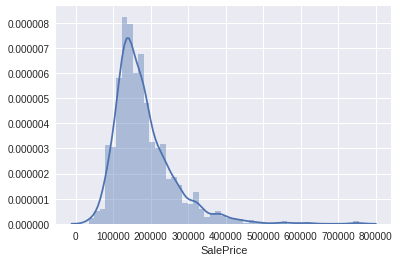

In [11]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

In [12]:
## Log transformation of labels
train_labels = np.log(train_labels)

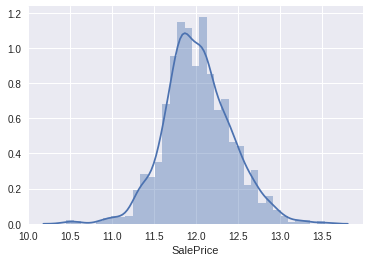

In [13]:
## Now it looks much better
ax = sns.distplot(train_labels)

### Splitting train and test features

In [14]:
train_features = features.loc['train']
train_features.drop('Id', axis = 1 , inplace = True)
test_features = features.loc['test']
index = test_features['Id']
test_features.drop('Id', axis = 1 , inplace = True)

/home/shubham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/shubham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
test_features.shape

(1459, 354)

In [16]:
train_features.head()

,LotFrontage,LotArea,MasVnrArea,GrLivArea,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.150685,0.033420,0.12250,0.259231,0,2.0,0.368280,0.000000,0.082210,0.000000,...,0,0,0,1,0,0,0,0,1,0
1,0.202055,0.038795,0.00000,0.174830,1,2.0,0.309140,0.209270,0.000000,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,0.160959,0.046507,0.10125,0.273549,1,2.0,0.408602,0.000000,0.056604,0.000000,...,0,0,0,1,0,0,0,0,1,0
3,0.133562,0.038561,0.00000,0.260550,1,3.0,0.431452,0.000000,0.047170,0.268775,...,0,0,0,1,1,0,0,0,0,0
4,0.215753,0.060576,0.21875,0.351168,1,3.0,0.561828,0.134831,0.113208,0.000000,...,0,0,0,1,0,0,0,0,1,0


### Defining functions to measure accuracy

In [17]:
# Prints R2 and RMSE scores
def get_score(prediction, label):    
    print('R2: {}'.format(r2_score(prediction, label)))
    print('RMSE: {}'.format(mean_squared_error(prediction, label)))

### Splitting into training and testing data

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size = 0.2, random_state=0)

/home/shubham/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Implementing our model

### Elastic Net

In [19]:
from sklearn import ensemble, tree, linear_model
clf = linear_model.ElasticNetCV(l1_ratio=[0.1,0.5,0.7,0.9,0.95,0.99,1],alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], max_iter = 5000)
clf.fit(X_train, y_train)
get_score(clf.predict(X_test), y_test)

R2: 0.808615800647
RMSE: 0.0298627710914


In [20]:
# Average R2 score and standart deviation of 10-fold cross-validation
scores = cross_val_score(clf, train_features, train_labels, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.10)


### Using gradient boosting with hyperparamter tuning

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
clf1 = GradientBoostingRegressor()

#Create the parameters list we wish to tune
parameters = {'learning_rate':[0.01,0.05,0.1], 'n_estimators':[100,1000,2000], 'max_features':['sqrt', 'log2']}

#Make an fbeta_score scoring object
scorer = make_scorer(r2_score)

#Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf1, parameters, scoring=scorer)

#Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_


/home/shubham/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [22]:
best_clf

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [23]:
best_clf.fit(X_train, y_train)
pred = best_clf.predict(X_test)
get_score(pred, y_test)

R2: 0.889966752314
RMSE: 0.0157442250479


### Ensembling final model

In [24]:
# Retraining models
GB_model = best_clf.fit(train_features, train_labels)
ENet_model = clf.fit(train_features, train_labels)

final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENet_model.predict(test_features))) / 2

pd.DataFrame({'Id': index, 'SalePrice': final_labels}).to_csv('submission.csv', index =False)   